In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [21]:
df = pd.read_csv("data/data.csv")
df = df.rename(columns={' Usage':'Usage',' pixels':'pixels'})
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [28]:
# convert pixel column to a usable form

def convert_pixels(column):
    
    new_column = column.copy()
    for i in range(len(new_column)):
        mlist = list(map( int, new_column[i].split(sep= ' ', maxsplit=-1))) # convert string to int list
        new_column[i] = [mlist[i * 48:(i + 1) * 48] for i in range((len(mlist) + 48 - 1) // 48 )] # convert into sublists
    return new_column

df['pixels'] = convert_pixels(df['pixels'])
df.head()

,emotion,Usage,pixels
0,0,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,Training,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."


In [25]:
df.info(), len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
Usage      35887 non-null object
pixels     35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


(None, 35887)

In [24]:
count = pd.DataFrame(df['emotion'].value_counts()).sort_index()

emotions = ['Angry','Disgust','Fear','Happy','Sad','Suprise','Neutral']

emotions_count = pd.DataFrame()
emotions_count['emotions'] = emotions
emotions_count['count'] = count

emotions_count

,emotions,count
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Suprise,4002
6,Neutral,6198


Text(0.5, 1.0, 'Count of each emotion')

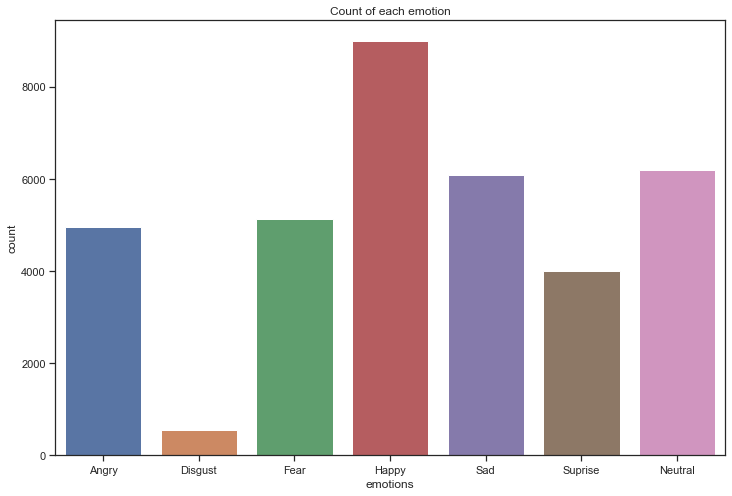

In [213]:
plt.figure(figsize=(12,8))
sns.barplot(emotions_count['emotions'],emotions_count['count'])
plt.title('Count of each emotion')

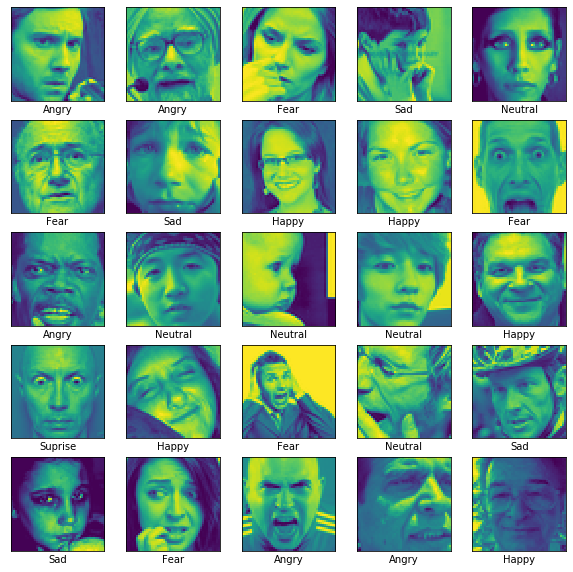

In [34]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    example = df.iloc[i,:]
    
    plt.imshow(example['pixels'])
    plt.xlabel(emotions[example['emotion']])
plt.show()

In [35]:
import tensorflow as tf
from tensorflow import keras

In [36]:
# shuffle dataframe

data = df.sample(frac=1).reset_index(drop=True)
data.head()

,emotion,Usage,pixels
0,4,Training,"[[0, 12, 28, 34, 38, 42, 46, 49, 52, 55, 58, 6..."
1,4,Training,"[[169, 168, 169, 173, 173, 173, 173, 172, 172,..."
2,3,PublicTest,"[[255, 255, 255, 255, 245, 166, 153, 153, 151,..."
3,5,Training,"[[51, 43, 45, 47, 45, 41, 38, 38, 48, 53, 67, ..."
4,0,Training,"[[166, 160, 148, 142, 162, 142, 132, 144, 144,..."


In [37]:
# Turn grayscale to RGB & normalize
# shape: (:,48,48,3)

def toRGB(column):    
    new_column = column.copy()
    rgb = np.empty((len(new_column),48,48,3),dtype=np.float64)
    
    for i in range(len(new_column)):
        for j in range(3):
            rgb[i,:,:,j] = np.array(new_column[i])/255
    return rgb

train = toRGB(data['pixels'])
train.shape

(35887, 48, 48, 3)

In [38]:
labels = np.reshape(np.array(data['emotion']),(-1,1))
labels.shape

(35887, 1)

In [135]:
split = int(len(train)*0.8)

train_data = train[:split]
val_data = train[:split]

train_labels = labels[:split]
val_labels = labels[:split]

In [215]:
IMG_SHAPE = (48, 48, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

C:\Users\Jordan\AppData\Roaming\Python\Python37\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [216]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax')

])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 7)               

In [217]:
# Train only top layer

history_top = model.fit(train_data, train_labels,
                    batch_size=32,
                    epochs=10,
                    validation_data=(val_data,val_labels))

tf.keras.models.save_model(model,"models\\tl_top")

print('\nhistory dict:', history_top.history)

Train on 28709 samples, validate on 28709 samples
Epoch 1/10
28709/28709 [==============================] - 345s 12ms/sample - loss: 1.9092 - accuracy: 0.2181 - val_loss: 1.8300 - val_accuracy: 0.2473
Epoch 2/10
28709/28709 [==============================] - 336s 12ms/sample - loss: 1.8063 - accuracy: 0.2525 - val_loss: 1.8063 - val_accuracy: 0.2505
Epoch 3/10
28709/28709 [==============================] - 402s 14ms/sample - loss: 1.7703 - accuracy: 0.2722 - val_loss: 1.7906 - val_accuracy: 0.2622
Epoch 4/10
28709/28709 [==============================] - 368s 13ms/sample - loss: 1.7581 - accuracy: 0.2866 - val_loss: 1.7926 - val_accuracy: 0.2656
Epoch 5/10
28709/28709 [==============================] - 447s 16ms/sample - loss: 1.7437 - accuracy: 0.2922 - val_loss: 1.7945 - val_accuracy: 0.2663
Epoch 6/10
28709/28709 [==============================] - 352s 12ms/sample - loss: 1.7322 - accuracy: 0.2970 - val_loss: 1.7923 - val_accuracy: 0.2682
Epoch 7/10
28709/28709 [====================

In [219]:
# Fine tune at layer 100/155

base_model.trainable = True
fine_tune_at = 100 # Fine-tune from this layer onwards

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_100 = model.fit(train_data, train_labels,
                    batch_size=32,
                    epochs=10,
                    validation_data=(val_data,val_labels))

tf.keras.models.save_model(model,"models\\tl_100")

print('\nhistory dict:', history_100.history)

Train on 28709 samples, validate on 28709 samples
Epoch 1/10


Exception ignored in: <function EagerResourceDeleter.__del__ at 0x00000145EFC691F8>
Traceback (most recent call last):
  File "c:\users\jordan\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 273, in __del__
    self._handle, ignore_lookup_error=True)
  File "c:\users\jordan\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\gen_resource_variable_ops.py", line 310, in destroy_resource_op
    "ignore_lookup_error", ignore_lookup_error)
KeyboardInterrupt: 


28709/28709 [==============================] - 1294s 45ms/sample - loss: 1.6395 - accuracy: 0.3556 - val_loss: 4.1992 - val_accuracy: 0.2695
Epoch 2/10
28709/28709 [==============================] - 469s 16ms/sample - loss: 1.5246 - accuracy: 0.4093 - val_loss: 3.3300 - val_accuracy: 0.3024
Epoch 3/10
28709/28709 [==============================] - 446s 16ms/sample - loss: 1.4461 - accuracy: 0.4458 - val_loss: 3.4537 - val_accuracy: 0.2905
Epoch 4/10
28709/28709 [==============================] - 440s 15ms/sample - loss: 1.3749 - accuracy: 0.4761 - val_loss: 3.3242 - val_accuracy: 0.3129
Epoch 5/10
28709/28709 [==============================] - 436s 15ms/sample - loss: 1.3150 - accuracy: 0.5049 - val_loss: 4.7564 - val_accuracy: 0.3005
Epoch 6/10
28709/28709 [==============================] - 444s 15ms/sample - loss: 1.2424 - accuracy: 0.5329 - val_loss: 4.4162 - val_accuracy: 0.2976
Epoch 7/10
28709/28709 [==============================] - 440s 15ms/sample - loss: 1.1767 - accuracy: 0.

In [137]:
# Train entire model

base_model.trainable = True

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_w = model.fit(train_data, train_labels,
                    batch_size=32,
                    epochs=10,
                    validation_data=(val_data,val_labels))

tf.keras.models.save_model(model,"models\\tl_w")

print('\nhistory dict:', history_w.history)

Train on 28709 samples, validate on 28709 samples
Epoch 1/10
28709/28709 [==============================] - 1068s 37ms/sample - loss: 0.2241 - accuracy: 0.9329 - val_loss: 0.3147 - val_accuracy: 0.9494
Epoch 2/10
28709/28709 [==============================] - 743s 26ms/sample - loss: 0.2213 - accuracy: 0.9362 - val_loss: 0.2077 - val_accuracy: 0.9599
Epoch 3/10
28709/28709 [==============================] - 667s 23ms/sample - loss: 0.2094 - accuracy: 0.9389 - val_loss: 0.1095 - val_accuracy: 0.9759
Epoch 4/10
28709/28709 [==============================] - 659s 23ms/sample - loss: 0.2129 - accuracy: 0.9386 - val_loss: 0.2219 - val_accuracy: 0.9591
Epoch 5/10
28709/28709 [==============================] - 661s 23ms/sample - loss: 0.2005 - accuracy: 0.9412 - val_loss: 0.1506 - val_accuracy: 0.9721
Epoch 6/10
28709/28709 [==============================] - 672s 23ms/sample - loss: 0.2079 - accuracy: 0.9396 - val_loss: 0.1608 - val_accuracy: 0.9705
Epoch 7/10
28709/28709 [===================

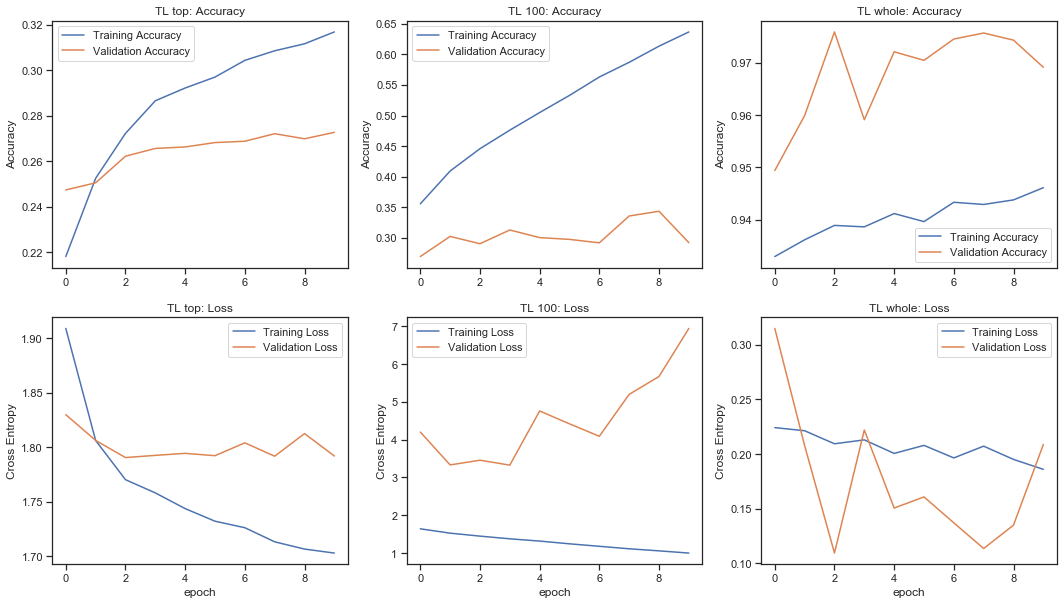

In [221]:
def plot_curves(names, histories):
    
    plt.figure(figsize=(18,10))
    for i in range(len(names)):
        plot_curve(names[i], histories[i], i+1)
    plt.show()
    
def plot_curve(name, data, order):
    
    acc = data.history['accuracy']
    val_acc = data.history['val_accuracy']
    
    loss = data.history['loss']
    val_loss = data.history['val_loss']
    
    plt.subplot(2,3,order)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.title(name + ': Accuracy')

    plt.subplot(2, 3, order+3)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.ylabel('Cross Entropy')
    plt.title(name + ': Loss')
    plt.xlabel('epoch')
    
names = ['TL top','TL 100','TL whole']
histories = [history_top, history_100, history_w]
plot_curves(names,histories)

In [166]:
confusion_matrix = tf.math.confusion_matrix(val_labels,np.argmax( model.predict(val_data), axis=1))
confusion_matrix

<tf.Tensor: id=696905, shape=(7, 7), dtype=int32, numpy=
array([[3890,    2,   42,   23,   18,    1,   37],
       [   2,  430,    5,    0,    8,    1,    1],
       [  49,    2, 3944,   13,   49,   14,   27],
       [   4,    0,   17, 7085,   21,    2,    9],
       [  57,    0,   65,   22, 4627,    0,   82],
       [  29,    1,   70,   38,    9, 3030,   25],
       [  21,    0,   24,   51,   45,    0, 4817]])>

In [174]:
def F1_score(confusion_matrix):
    f1_score = []
    
    for i in range(len(confusion_matrix)):
        TP = int( confusion_matrix[i,i] )
        FN = np.sum(confusion_matrix[i,:]) - TP
        FP = np.sum(confusion_matrix[:,i]) - TP
        TN = np.sum(confusion_matrix) - FN - FP + TP
        
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        
        score = 2*precision*recall/(precision+recall)
        
        f1_score.append(score)
        
    return f1_score
    
f1score = F1_score(confusion_matrix)
f1score

[0.9646621202727836,
 0.9750566893424036,
 0.9543859649122808,
 0.9860821155184412,
 0.9609553478712357,
 0.9695999999999999,
 0.967657693852953]

Text(0, 0.5, 'F1 Score')

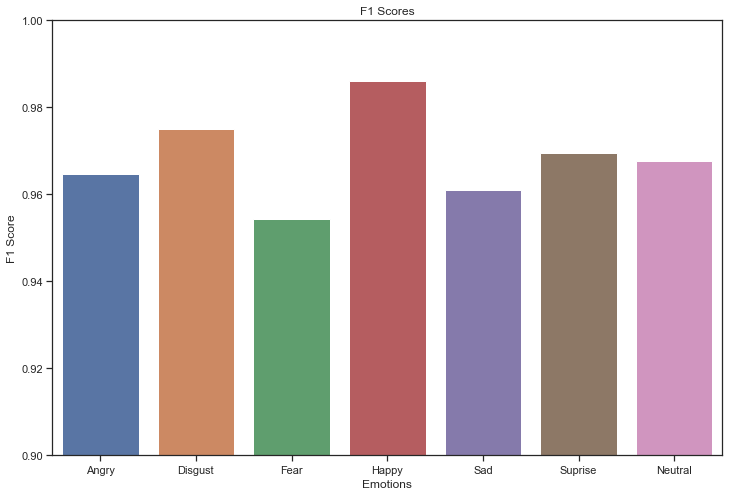

In [210]:
fig = plt.figure(figsize=(12,8))

ax = plt.gca()

fig = sns.set_style('ticks')

sns.barplot(emotions,f1score)
plt.title('F1 Scores')

#plt.yticks(np.arange(0.8,1,0.01))

ax.set_ylim([0.9,1])

plt.xlabel('Emotions')
plt.ylabel('F1 Score')

In [ ]:
# disgust and surprise was difficult to obtain on webcam
# apply data augmentation to increase datatset 

In [227]:
# Obtain disgust and surprise data

disgust_data = []
surprise_data = []

for i in range(len(train)):
    if labels[i] == 1:
        disgust_data.append(train[i])
    elif labels[i] == 5:
        surprise_data.append(train[i])

In [232]:
unaug_disgust = tf.convert_to_tensor(disgust_data,dtype=np.float64)
unaug_surprise = tf.convert_to_tensor(surprise_data,dtype=np.float64)

# Data Augmentation
bright_dis1 = tf.image.adjust_brightness(unaug_disgust,0.3)
bright_dis2 = tf.image.adjust_brightness(unaug_disgust,0.7)
flip_dis = tf.image.flip_left_right(unaug_disgust)
rot90_dis = tf.image.rot90(unaug_disgust,k=1)
rot270_dis = tf.image.rot90(unaug_disgust,k=3)

aug_disgust = tf.concat([bright_dis1,bright_dis2,flip_dis,rot90_dis,rot270_dis],0)
aug_surprise = tf.image.flip_left_right(unaug_surprise)

aug_disgust.shape, aug_surprise.shape

(TensorShape([2735, 48, 48, 3]), TensorShape([4002, 48, 48, 3]))

In [262]:
aug_dis_labels = tf.reshape( tf.convert_to_tensor( [1]*emotions_count['count'][1]*5,dtype=np.int64 ), (-1,1))
aug_sur_labels = tf.reshape( tf.convert_to_tensor( [5]*emotions_count['count'][5],dtype=np.int64 ), (-1,1))

aug_dis_labels.shape, aug_sur_labels.shape

(TensorShape([2735, 1]), TensorShape([4002, 1]))

In [257]:
unaug_x = tf.convert_to_tensor(train, dtype=np.float64)
unaug_y = tf.convert_to_tensor(labels)

unaug_x.shape, unaug_y.shape

(TensorShape([35887, 48, 48, 3]), TensorShape([35887, 1]))

In [263]:
aug_x = tf.concat([unaug_x,aug_disgust,aug_surprise],0)
aug_y = tf.concat([unaug_y,aug_dis_labels, aug_sur_labels],0)

aug_x.shape, aug_y.shape

(TensorShape([42624, 48, 48, 3]), TensorShape([42624, 1]))

In [264]:
tf.random.set_seed(0)
tf.random.shuffle(aug_x,seed=0)

tf.random.set_seed(0)
tf.random.shuffle(aug_y,seed=0)

<tf.Tensor: id=889819, shape=(42624, 1), dtype=int64, numpy=
array([[4],
       [5],
       [6],
       ...,
       [6],
       [1],
       [4]], dtype=int64)>

In [278]:
split = int(aug_x.shape[0]*0.8)

atrain_data = aug_x[:split]
atrain_labels = aug_y[:split]

aval_data = aug_x[split:]
aval_labels = aug_y[split:]

In [282]:
# Train entire model

base_model.trainable = True

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_augw = model.fit(atrain_data,atrain_labels,
                    batch_size=32,
                    epochs=10,
                    validation_data=(aval_data,aval_labels))

tf.keras.models.save_model(model,"models\\tl_augw")

print('\nhistory dict:', history_augw.history)

Train on 34099 samples, validate on 8525 samples
Epoch 1/10
34099/34099 [==============================] - 805s 24ms/sample - loss: 1.0925 - accuracy: 0.6049 - val_loss: 3.5502 - val_accuracy: 0.5006
Epoch 2/10
34099/34099 [==============================] - 701s 21ms/sample - loss: 1.0138 - accuracy: 0.6340 - val_loss: 3.4945 - val_accuracy: 0.4853
Epoch 3/10
34099/34099 [==============================] - 706s 21ms/sample - loss: 0.9403 - accuracy: 0.6613 - val_loss: 3.8301 - val_accuracy: 0.4561
Epoch 4/10
34099/34099 [==============================] - 703s 21ms/sample - loss: 0.8752 - accuracy: 0.6859 - val_loss: 4.6780 - val_accuracy: 0.4830
Epoch 5/10
34099/34099 [==============================] - 702s 21ms/sample - loss: 0.8154 - accuracy: 0.7117 - val_loss: 3.8211 - val_accuracy: 0.4612
Epoch 6/10
34099/34099 [==============================] - 709s 21ms/sample - loss: 0.7539 - accuracy: 0.7333 - val_loss: 5.1930 - val_accuracy: 0.4484
Epoch 7/10
34099/34099 [=====================